VADER-Based Sentiment Analysis on Tweets V/S Roberta based transformer from hugging face for sentiment analysis using NLP



1.first we are going to start with VADER-Based sentiment analysis

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.style.use("ggplot")

In [ ]:
# Load the dataset
df = pd.read_csv("twitter_data_500.csv", header=None, names=["textID", "text"])
print(df.iloc[3:])

         textID                                               text
3    549e992a42      Sooo SAD I will miss you here in San Diego!!!
4    088c60f138                          my boss is bullying me...
5    9642c003ef                     what interview! leave me alone
6    358bd9e861   Sons of ****, why couldn`t they put them on t...
7    28b57f3990  http://www.dothebouncy.com/smf - some shameles...
..          ...                                                ...
496  7082999a93  According to , a quarter of families under six...
497  cf29e364fe      the plan to not spend money is not going well
498  ea567e664a    uploading all my bamboozle pictures of facebook
499  912bbdea65   congratulations ! you guys finish a month ear...
500  060d8bb5d5   actually, I wish I was back in Tahoe.  I miss...

[498 rows x 2 columns]


In [ ]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze each tweet and store results
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    myid = row['textID']
    if isinstance(text, str):
        results[myid] = sia.polarity_scores(text)
    else:
        results[myid] = {"neg": 0, "neu": 0, "pos": 0, "compound": 0}

  0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
# Convert the results to DataFrame
vader = pd.DataFrame(results).T
vader = vader.reset_index().rename(columns={"index": "textID"})
vader = vader.merge(df, on="textID", how="left")

# Labeling sentiment based on compound score
vader['Label'] = vader['compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))
output=vader.drop('textID', axis=1)
print(output)

       neg    neu    pos  compound  \
0    0.000  1.000  0.000    0.0000   
1    0.000  1.000  0.000    0.0000   
2    0.000  1.000  0.000    0.0000   
3    0.474  0.526  0.000   -0.7437   
4    0.494  0.506  0.000   -0.5994   
..     ...    ...    ...       ...   
496  0.268  0.732  0.000   -0.5106   
497  0.168  0.832  0.000   -0.2057   
498  0.294  0.706  0.000   -0.3612   
499  0.000  0.682  0.318    0.6360   
500  0.142  0.619  0.239    0.2732   

                                                  text     Label  
0                                                 text   neutral  
1                                                 text   neutral  
2                  I`d have responded, if I were going   neutral  
3        Sooo SAD I will miss you here in San Diego!!!  negative  
4                            my boss is bullying me...  negative  
..                                                 ...       ...  
496  According to , a quarter of families under six...  negative  
497    

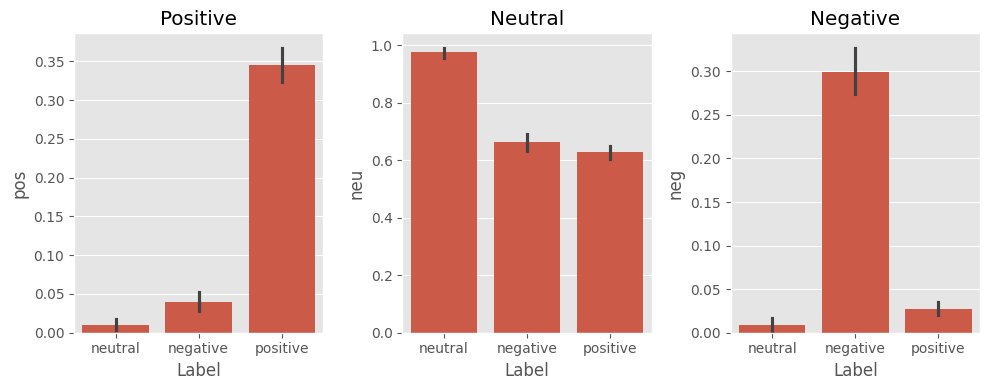

In [ ]:
# Visualize sentiment distribution
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.barplot(data=vader, x="Label", y="pos", ax=axs[0])
sns.barplot(data=vader, x="Label", y="neu", ax=axs[1])
sns.barplot(data=vader, x="Label", y="neg", ax=axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()


2.Now we gonna use Robverta Based transformer from Huggingface

In [ ]:
#roberta based tweet sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
df1 = pd.read_csv("twitter_data_500.csv", header=None)
df1.columns = ['textID', 'text']
def polarity_scores_roberta(texts):
    neg = []
    neu = []
    pos = []
    for text in texts:
        if not isinstance(text, str) or text.strip() == "":
            neg.append(0)
            neu.append(0)
            pos.append(0)
            continue
        encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            output = model(**encoded)
        scores = output.logits[0].numpy()
        scores = softmax(scores)
        neg.append(scores[0])
        neu.append(scores[1])
        pos.append(scores[2])
    return neg, neu, pos
neg, neu, pos = polarity_scores_roberta(df1["text"].tolist())
df1['roberta_neg'] = neg
df1['roberta_neu'] = neu
df1['roberta_pos'] = pos
# Display results, excluding the 'text' column
display(df1.drop('text', axis=1).head(10))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,textID,roberta_neg,roberta_neu,roberta_pos
0,textID,0.254576,0.511313,0.234111
1,textID,0.254576,0.511313,0.234111
2,cb774db0d1,0.064939,0.808318,0.126744
3,549e992a42,0.918158,0.066100,0.015742
4,088c60f138,0.924613,0.070741,0.004646
5,9642c003ef,0.783082,0.192980,0.023938
6,358bd9e861,0.564197,0.404575,0.031229
7,28b57f3990,0.116091,0.404589,0.479320
8,6e0c6d75b1,0.001926,0.027040,0.971034
9,50e14c0bb8,0.063866,0.503986,0.432148
